## Yield Curve Calculations

### Installing and Importing necessary modules
Note: I am using Python 3.12
This cell imports various libraries required for data manipulation (`pandas`), symbolic mathematics (`sympy`), visualization (`matplotlib`, `seaborn`), and optimization (`scipy`). Additionally, it sets up the IPython environment for inline plotting and LaTeX rendering.


In [57]:
#!pip install pandas sympy IPython matplotlib numpy seaborn scipy pprint

In [58]:
from sympy import *
from sympy import pi as sp_pi
from sympy import E as sp_e

from IPython.display import display
from IPython.core.display import Math

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import scale as mscale

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from pprint import pprint

init_session(use_latex=True)
init_printing(use_latex='mathjax')

IPython console for SymPy 1.12 (Python 3.12.3-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/


### 1. Defining and solving initial function

#### Defining token sale constants
Defining constants explained above

##### Time-based Parameters

In [59]:
FREQUENCY_CALC = 24
T_SALE_DAYS = 7
T_TOTAL_WEEKS = 16

T_SALE_HOURS = T_SALE_DAYS * FREQUENCY_CALC
T_TOTAL_HOURS = T_TOTAL_WEEKS * 7 * FREQUENCY_CALC

T_TOTAL_HOURS_PLUS_ONE = T_TOTAL_HOURS + 1

##### SUPERy (Y) Parameters

In [60]:
MAXIMUM_SUPPLY_SUPER_Y = 20000000
SUPER_Y_EMITTED_DURING_SALE = 6000000

#### Defining Symbols and Solving Equations
This cell defines the symbolic variables and the equations needed for the problem. It formulates a symbolic expression for `y` and sets up three equations based on given conditions. The system of equations is then solved symbolically to find the values of `a`, `b`, and `c`.


In [61]:
# Define symbols
a, b, c, d, f, x, y = symbols('a b c d f x y')

y = simplify((0.5 * a * x**2) + (b * ln((sp_e * x) + c)))

# Define the equations
eq1 = Eq(y.subs({x:0}), 0)
eq2 = Eq(y.subs({x:T_TOTAL_HOURS}), MAXIMUM_SUPPLY_SUPER_Y)
eq3 = Eq(y.subs({x:T_SALE_HOURS}), SUPER_Y_EMITTED_DURING_SALE)

# Solve the system of equations symbolically
solution_symbolic = solve((eq1, eq2, eq3), (a, b, c))

a_solution = solution_symbolic[0][0]
pprint(f"a = {a_solution}")
b_solution = solution_symbolic[0][1]
pprint(f"b = {b_solution}")
c_solution = solution_symbolic[0][2]
pprint(f"c = {c_solution}")

a = 3.14196953278625
b = 972169.995739736
c = 1.00000000000000


### 2. Optimizing initial equation

#### Recalculating with New Assumption
Based on the previous solution where `a` is approximately equal to π, this cell sets `a` to π and recalculates the expression for `y`. New equations are defined and solved symbolically to find updated values for `d` and `f`, which are placeholder for `b` and `c`.


In [62]:
pprint(f'Since {a_solution} =~ π, well set a = π and recalculate')

y_new = (0.5 * sp_pi * x**2) + (d * ln((sp_e * x) + f))

# Define the equations
eq4 = Eq(y_new.subs({x:0}), 0)
eq5 = Eq(y_new.subs({x:T_TOTAL_HOURS}), MAXIMUM_SUPPLY_SUPER_Y)
eq6 = Eq(y_new.subs({x:T_SALE_HOURS}), SUPER_Y_EMITTED_DURING_SALE)

solution_symbolic = solve((eq4, eq5), (d, f))
b_solution = round(solution_symbolic[0][0])
pprint(f"b = {b_solution}")
c_solution = solution_symbolic[0][1]
pprint(f"c = {c_solution}")

Since 3.14196953278625 =~ π, well set a = π and recalculate
b = 972323
c = 1.00000000000000


#### Optimization to Find True Value of b
This cell uses the previously calculated `b_solution` as an initial guess to find the true value of `b` through numerical optimization. The `calculate_yield` function defines the hourly yield, and the `objective` function calculates the sum of the yields to minimize the difference from the target sum. The `minimize` function from `scipy.optimize` is used to perform the optimization.


In [63]:
pprint(f'Due to the nature of integration, we can use b = {b_solution} as the initial guess to find the true value for b')


# Constants
e = np.exp(1)
pi = np.pi


# Define the function that calculates the hourly yield
def calculate_yield(b_term, hour_time_values):
    return np.pi * hour_time_values + b_term * e / (e * hour_time_values + 1)


# Objective function that we want to minimize
def objective(b_term, hour_time_values, target):
    # Calculate yield
    calculated_yield = calculate_yield(b_term, hour_time_values)
    # Calculate the sum of yield and the difference from the target
    return abs(np.sum(calculated_yield) - target)


# time values (from 0 to 2689)
hour_time_values = np.arange(0, T_TOTAL_HOURS_PLUS_ONE)

# Target sum for yield
target_sum = MAXIMUM_SUPPLY_SUPER_Y

# Initial guess for b_term
initial_guess = [b_solution]

# Run the optimization
result = minimize(objective, initial_guess, args=(hour_time_values, target_sum), method='TNC')
optimized_b_term = None
# Check if the optimization was successful
if result.success:
    optimized_b_term = round(result.x[0])
    print("Optimized b value:", optimized_b_term)
else:
    print("Optimization failed:", result.message)


Due to the nature of integration, we can use b = 972323 as the initial guess t
o find the true value for b
Optimized b value: 807305


#### Simplifying Function and Calculating Derivative
This cell simplifies the function `F(x)` using the optimized value of `b` and the calculated value of `c`. It then computes the derivative of `F(x)`, which is denoted as `f(x)`.


In [64]:
e = exp(1)
pi = sp_pi

F = simplify((0.5 * pi * x**2) + (optimized_b_term * ln((sp_e * x) + c_solution)))

pprint(f"Simplified F(x) = {F}")

f = Derivative(F, x, evaluate = True)

pprint(f"Derivative of F(x) = f(x) = {f}")


Simplified F(x) = 0.5*pi*x**2 + 807305*log(E*x + 1.0)
Derivative of F(x) = f(x) = 1.0*pi*x + 807305*E/(E*x + 1.0)


#### Calculating the Constant of Integration
This cell calculates the constant of integration, `C`, for the function `F(x)` using the definite integral of `f(x)`. It sets up an equation with the target value and solves for `C`. The function `F(x)` is then updated to include this constant.


In [65]:
pprint("Now, the constant of integration C must be calculated for F(x) using f(x)")

C = symbols('C')

f_definite_integral = Eq(MAXIMUM_SUPPLY_SUPER_Y, Integral(f, (x, 0, T_TOTAL_HOURS)) + C)
display(f_definite_integral.evalf())

C_value = round(solve(f_definite_integral, C)[0])
pprint(f"C is: {C_value}")


F = F + C_value
pprint(f"F(x) with C: {F}")


Now, the constant of integration C must be calculated for F(x) using f(x)


                 2688                         
                  ⌠                           
                  ⎮   ⎛           807305⋅ℯ⎞   
20000000.0 = C +  ⎮   ⎜1.0⋅π⋅x + ─────────⎟ dx
                  ⎮   ⎝          ℯ⋅x + 1.0⎠   
                  ⌡                           
                  0                           

C is: 1468114
F(x) with C: 0.5*pi*x**2 + 807305*log(E*x + 1.0) + 1468114


### 3. Preparing data for charting

#### Converting SymPy Functions to NumPy Functions
This cell uses `lambdify` to convert the symbolic expressions for the derivative `f(x)` and the function `F(x)` into numerical functions that can be evaluated using NumPy.


In [66]:
np_f = lambdify(x, f, 'numpy')
np_F = lambdify(x, F, 'numpy')

#### Converting Functions to LaTeX for Chart Display
This cell converts the symbolic expression for the derivative `f(x)` into a LaTeX string, makes some formatting adjustments, and then displays the formatted LaTeX string.

In [67]:

latex_f = latex(f)

latex_f = latex_f.replace(r"1.0", r"1")
latex_f = latex_f.replace(r"x", r"t")

#Remove 1 pi
latex_f = latex_f[2:]

latex_f_prefix = "f(t) = "
latex_f = latex_f_prefix + latex_f

display(Math(latex_f))


<IPython.core.display.Math object>

In [68]:
latex_F = latex(F)

latex_F = latex_F.replace(r"log", r"ln")
latex_F = latex_F.replace(r" 1.0 ", r" 1 ")
latex_F = latex_F.replace("0.5 \\pi x^{2}", "\\frac{\\pi x^{2}}{2}")
latex_F = latex_F.replace(r"x", r"t")

latex_F_prefix = r"displaystyle \int_0^{2688} f(t) \,  ="
latex_F = latex_F_prefix + latex_F

display(Math(latex_F))


<IPython.core.display.Math object>

#### Creating Date Labels for Plotting
This cell sets up the date labels for plotting, based on the chosen `date_type` which can be either "weeks" or specific "dates". It calculates the total hours for a 16-week period and generates corresponding x-values. Depending on the `date_type`, it creates appropriate date labels and tick positions for plotting.


In [69]:
#CREATES SPECIFIC DATES LLIKE 07-03 ETC.
date_type = "weeks"
start_date = '2024-06-05' #Only matters if date_type = dates

x_values = np.arange(start=0, stop=T_TOTAL_HOURS_PLUS_ONE, step=1)

date_labels = []
tick_positions = None

if date_type == 'weeks':
    date_labels = [f"{i}" for i in range(17)]
    tick_positions = np.linspace(x_values[0], len(x_values), len(date_labels))
elif date_type == 'dates':
    dates = pd.date_range(start=start_date, periods=16, freq='7D')
    date_labels = dates.strftime('%m-%d').tolist()
    tick_positions = np.linspace(x_values[0], len(x_values), len(date_labels))
else:
    pprint("select type")


#### Double-checking that the totals add up
This cell calculates the values of `f(x)` and `F(x)` using the previously defined NumPy functions. It then determines the total number of tokens for `F(x)` and `f(x)`. The constant `C` is computed as the difference between the sum of `f(x)` values and the maximum of `F(x)` values.


In [70]:
f_values = np_f(x_values)
F_values = np_F(x_values)


total_tokens_F = max(F_values)
pprint(F"Max value within integral = {total_tokens_F}")

total_tokens_f = sum(f_values)
pprint(f"Sum of all values in yield curve = {total_tokens_f}")

error_tolerance_fraction = 0.0001/100 #0.0001%
error_tolerance_value = MAXIMUM_SUPPLY_SUPER_Y * error_tolerance_fraction
pprint(f"\nTolerance: {error_tolerance_value}")
if (error_tolerance_value < abs(MAXIMUM_SUPPLY_SUPER_Y - total_tokens_F)) or (error_tolerance_value < abs(MAXIMUM_SUPPLY_SUPER_Y - total_tokens_f)):
    raise RuntimeError("\nTolerance not met!!!")
else:
    pprint("\nToken distribution within tolerance")

Max value within integral = 19999999.773960073
Sum of all values in yield curve = 20000000.61276604
               
Tolerance: 20.0
                                   
Token distribution within tolerance


### 4. Plotting

#### Setting Up Plot Style and Configuration
This cell creates the folder `super_charts`, where charts will be exported to


In [71]:
from os import makedirs
# Create a directory named 'super_charts'
directory = "super_charts"
makedirs(directory, exist_ok=True)

This cell sets the plotting style to `seaborn-v0_8-talk` and configures the plot size, resolution (DPI), and base font size for the plots. It also prints the available plot styles.

In [72]:
plt.style.use('seaborn-v0_8-talk')
figsize = (9,5)
dpii = 150
base_font_size = 10
axis_font_size = 14

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### Plotting SUPERy Hourly Yield Curve
This cell configures and plots the hourly emissions of SUPERy over time using the previously calculated derivative values. It sets the plot aesthetics, including font sizes and logarithmic scale for the y-axis. The plot includes annotations for key points in time and is saved in both PNG and SVG formats.


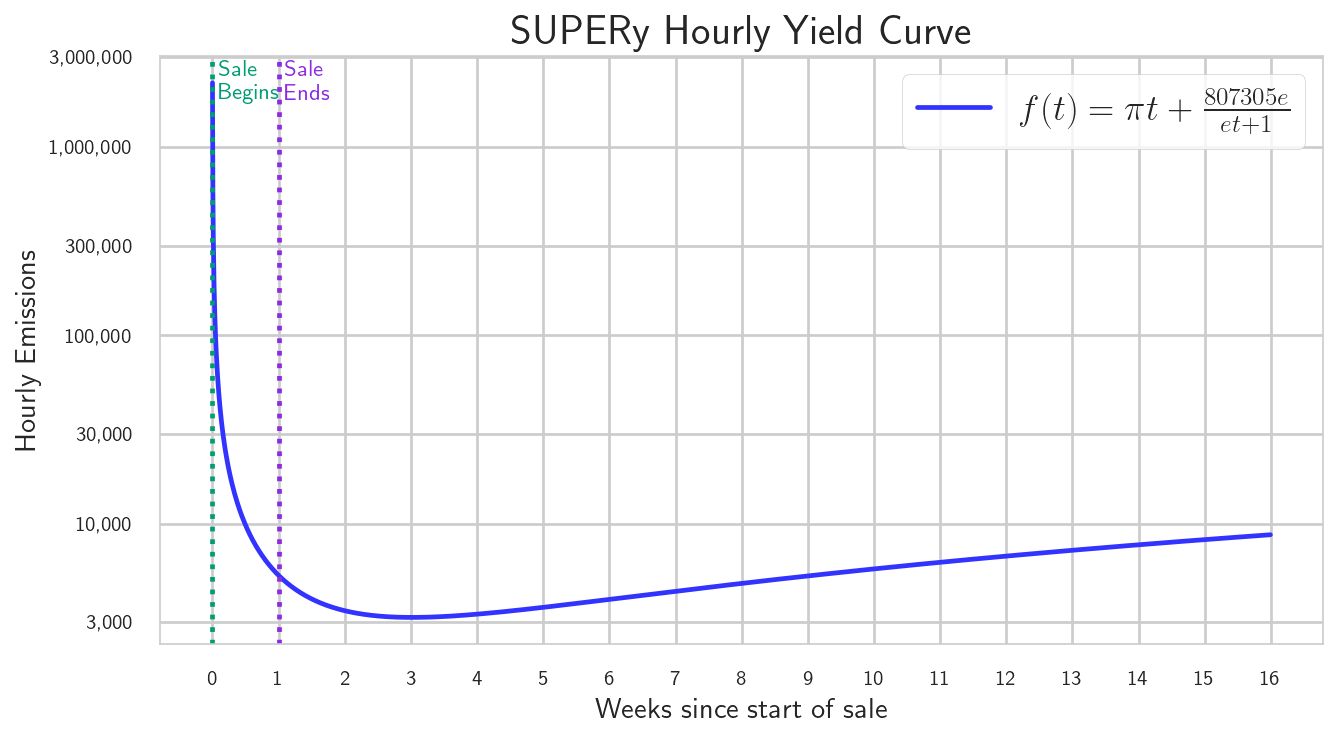

In [73]:
%matplotlib inline

# Plot Configuration
plt.figure(figsize=figsize, dpi=dpii)
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = base_font_size
plt.rcParams['ytick.labelsize'] = base_font_size
plt.rcParams['axes.labelsize'] = axis_font_size

# Plotting
ax = plt.gca()
plt.plot(x_values, f_values, label=rf'${latex_f}$', color='#3333ff')
plt.xticks(ticks=tick_positions, labels=date_labels, rotation=0)
plt.title('SUPERy Hourly Yield Curve', fontsize=2*base_font_size)  # Double the base font size for the title
plt.legend(prop={'family': 'Times New Roman', 'size': 1.75 * base_font_size, 'weight': 'bold'},frameon=True, facecolor='white')  # Adjust legend size

# Axis Labels
ax.set_ylabel('Hourly Emissions')
ax.set_xlabel('Weeks since start of sale')

# Logarithmic Scale
ax.set_yscale('log')
mscale.LogScale.base = 2  # Set base for log scale

# Custom Formatter
def custom_formatter(x, pos):
    return f'{x:,.0f}'
ax.yaxis.set_major_locator(ticker.FixedLocator([3000000, 1000000, 300000, 100000, 30000, 10000, 3000, 0]))  # 5 million
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

# Vertical Lines and Text Annotations
ylim = ax.get_ylim()
vertical_padding = (ylim[1] - ylim[0]) * 0.05
horizontal_padding = (tick_positions[1] - tick_positions[0]) * 0.1

plt.axvline(x=tick_positions[0], color=sns.color_palette('colorblind')[2], linestyle=':', label='First Point')
plt.text(tick_positions[0] + horizontal_padding, ylim[1] - vertical_padding, 'Sale\nBegins', ha='left', va='top',
         fontsize=11, color=sns.color_palette('colorblind')[2])

plt.axvline(x=tick_positions[1], color=sns.color_palette('bright')[4], linestyle=':', label='Second Point')
plt.text(tick_positions[1] + horizontal_padding, ylim[1] - vertical_padding, 'Sale\nEnds', ha='left', va='top',
         fontsize=11, color=sns.color_palette('bright')[4])


# Final Adjustments and Saving
plt.tight_layout(pad=1)
plt.savefig('./super_charts/hourly_yield.png', format='png', dpi=dpii)  # Match the dpi with the figure creation for consistency
plt.savefig('./super_charts/hourly_yield.svg', format='svg')

plt.show()


#### Plotting Total SUPERy Emitted over Time
This cell prepares and plots the total SUPERy emitted over time using the previously calculated values. It configures plot aesthetics, such as font sizes and plot style, and adds annotations for key points in time. The plot is saved in both PNG and SVG formats.


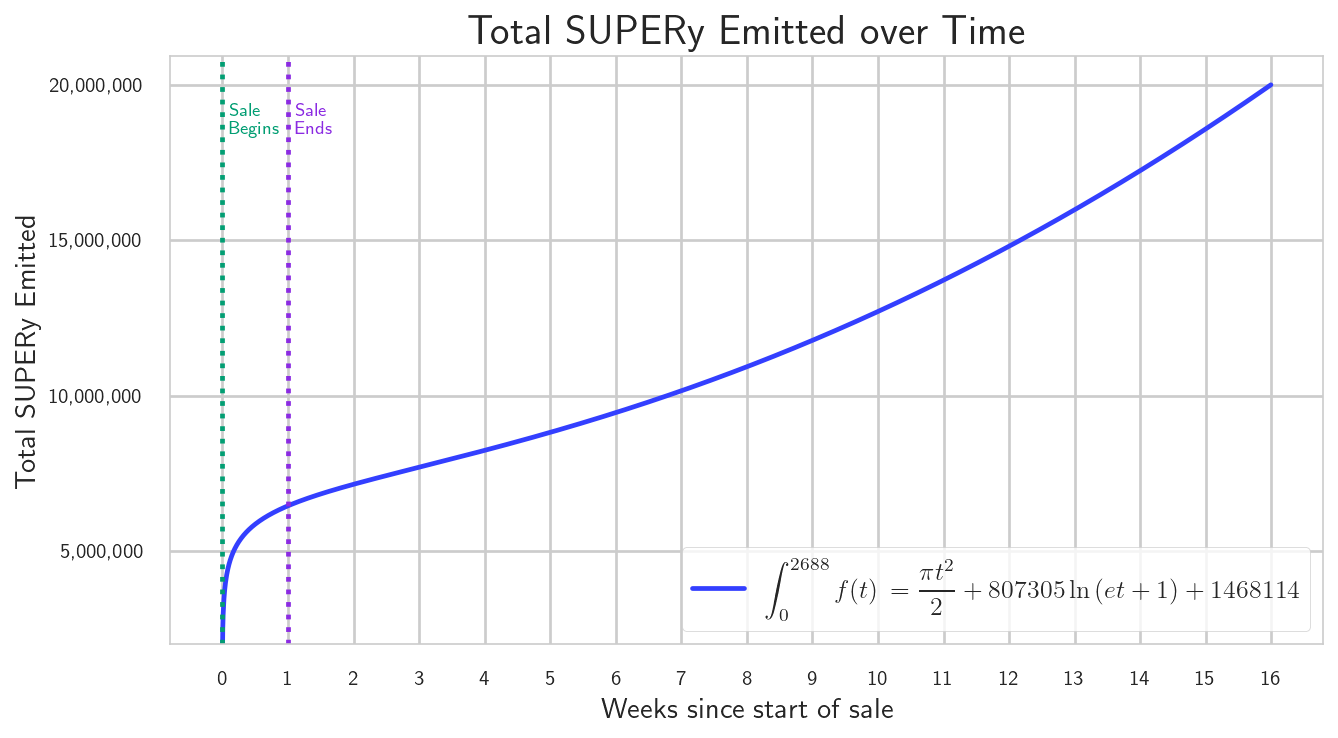

In [74]:
%matplotlib inline

# Plot Preparation
plt.figure(figsize=figsize, dpi=dpii)
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = base_font_size
plt.rcParams['ytick.labelsize'] = base_font_size
plt.rcParams['axes.labelsize'] = axis_font_size

# Plotting
plt.plot(x_values, F_values, label=rf'$\{latex_F}$', color='#333fff')
plt.xticks(ticks=tick_positions, labels=date_labels, rotation=0)
plt.title('Total SUPERy Emitted over Time', fontsize=2 * base_font_size)
plt.legend(prop={'family': 'Times New Roman', 'size': 1.25 * base_font_size, 'weight': 'bold'},frameon=True, facecolor='white')

# Axis Labels
ax = plt.gca()
ax.set_ylabel('Total SUPERy Emitted')
ax.set_xlabel('Weeks since start of sale')

# Custom Formatter
def custom_formatter(x, pos):
    return f'{x:,.0f}'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000000))  # 5 million
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2500000))  # 2.5 million

# Vertical Lines and Text Annotations
ylim = ax.get_ylim()
ax.set_ylim((ylim[0]+float(C_value), ylim[1]))
vertical_padding = (ylim[1] - ylim[0]) * 0.075
horizontal_padding = (tick_positions[1] - tick_positions[0]) * 0.1
plt.axvline(x=tick_positions[0], color=sns.color_palette('colorblind')[2], linestyle=':', label='First Point')
plt.text(tick_positions[0] + horizontal_padding, ylim[1] - vertical_padding, 'Sale\nBegins', ha='left', va='top',
         fontsize=0.85*base_font_size, color=sns.color_palette('colorblind')[2])
plt.axvline(x=tick_positions[1], color=sns.color_palette('bright')[4], linestyle=':', label='Second Point')
plt.text(tick_positions[1] + horizontal_padding, ylim[1] - vertical_padding, 'Sale\nEnds', ha='left', va='top',
         fontsize=0.85*base_font_size, color=sns.color_palette('bright')[4])

# Final Adjustments and Saving
plt.tight_layout(pad=1)
plt.savefig('./super_charts/total_yield.png', format='png', dpi=dpii)
plt.savefig('./super_charts/total_yield.svg', format='svg')
plt.show()


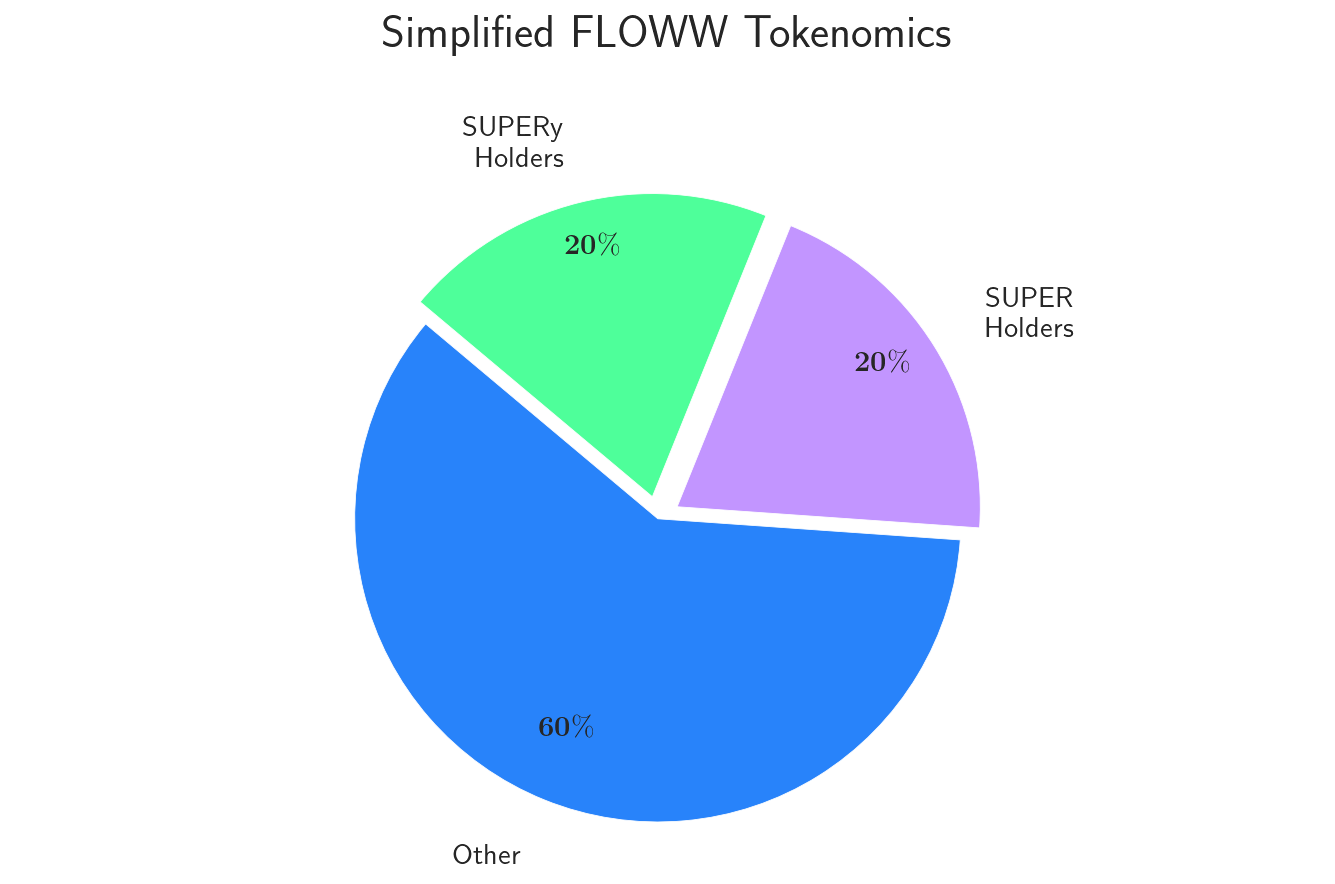

In [75]:
%matplotlib inline

tokenomics = {
    'Other': 60000000,
    'Early Investors': 20000000,
    'Early Investors - Yield-Allocation': 20000000,
}
plt.figure(figsize=(9, 6), dpi=dpii) #750dpi!!!!


plt.rcParams['text.usetex'] = True
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = (
    'Other',
    'SUPER\nHolders',
    'SUPERy\nHolders')

sizes =  (60000000, 20000000, 20000000)

colors = ['#2883fa', '#c295ff', '#4eff9a', '#fa3680', '#FFA15A', '#19D3F3']


explode = (0, 0.075, 0.075)  # Only "explode" the 2nd slice (i.e. 'LP of ${f}USD:XRD Pool')

# Function to format the autopct labels with LaTeX and increased font size
def autopct_format(values, fontsize=14):  # You can adjust the fontsize as needed
    def my_format(pct):
        total = sum(values)
        val = int(round(pct))
        # Formatting string with LaTeX and specifying fontsize
        return r'$\bf{{{val:,}}}\%$'.format(val=val) + '\n' + r'\fontsize{' + str(fontsize) + r'}{0}'  
    return my_format

wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct=autopct_format(sizes, fontsize=12), startangle=140, colors=colors, explode=explode, pctdistance=0.8, labeldistance=1.2)

# Making only the percentage labels bold, not the text labels

for text in plt.gca().texts:
    if '%' in text.get_text():
        text.set_fontsize(14)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts + autotexts:
    text.set_fontsize(14)  # Adjust this value as needed
    
plt.title('Simplified FLOWW Tokenomics', y=1.15, fontdict={'fontsize': 22, 'fontweight': 'bold'})

plt.tight_layout()
plt.savefig('./super_charts/simple_tokenomics.png', dpi=dpii)
plt.savefig('./super_charts/simple_tokenomics.svg', format='svg')

plt.show()
